In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Data Preparation for Semantic Segmentation

This notebook provides examples of further data preparation needed for semantic segmentation, namely creating semantic segmentation class masks and pre-sampling chips.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
import geopandas as gpd

## Getting Semantic Segmentation Class Objects with `collect_annotations.py`
Our goal is to train a semantic segmentation model that can identify buildings and solar panels. The training data consists of annotated vector geometries for these objects. However, to train our model, we need to convert these annotations into semantic segmentation masks.

We start by using the `collect_annotations.py` script. This script filters the raw annotations file to extract polygon geometries corresponding to buildings and solar panel polygon. It also combines these with additional annotations of backround region polygons.

Furthermore, we generate buffer polygons around buildings. The purpose of these buffer polygons is to help the model distinguish between buildings that are situated close together.

```bash
cd ./scripts/semantic_segmentation
python collect_annotations.py -c ../../config/examples/semantic_segmentation/collect_annotations.yml --root-dir $PROJECT_ROOT --raw-data-dir $RAW_DATA_ROOT
```
This script saves the annotations to `../data/interim/example_annotations/semantic_segmentation_classes-Kakuma_15.gpkg`. Let's inspect the results.

In [3]:
sem_seg_ann = gpd.read_file('../data/interim/example_annotations/semantic_segmentation_classes-Kakuma_15.gpkg')
print(sem_seg_ann.head(3))
print(sem_seg_ann['class'].value_counts())

        class                                           geometry
0  background  POLYGON ((705316.164 413040.965, 705288.876 41...
1  background  POLYGON ((705129.169 413398.611, 705086.090 41...
2  background  POLYGON ((705268.461 414219.781, 705208.873 41...
class
building_boundary    1465
building             1465
solar                 103
background             15
Name: count, dtype: int64


We see that the semantic segmentation annotations file contains polygon objects with a `class` column denoting which semantic class the object belongs to. We have 1465 buildings as well as a buffer or boundary polygon for each building, 103 solar polygons, and 15 background polygons. Note, when we used the full set of annotations rather than the sample provided for these example notebooks, we wound up with 10625 buildings, 10625 boundary polygons, 438 solar polygons, and 101 background polygons, all saved in a single `semantic_segmentation_classes.gpkg` file.

Let's visualize these shapes as well as the corresponding imagery for a small area.

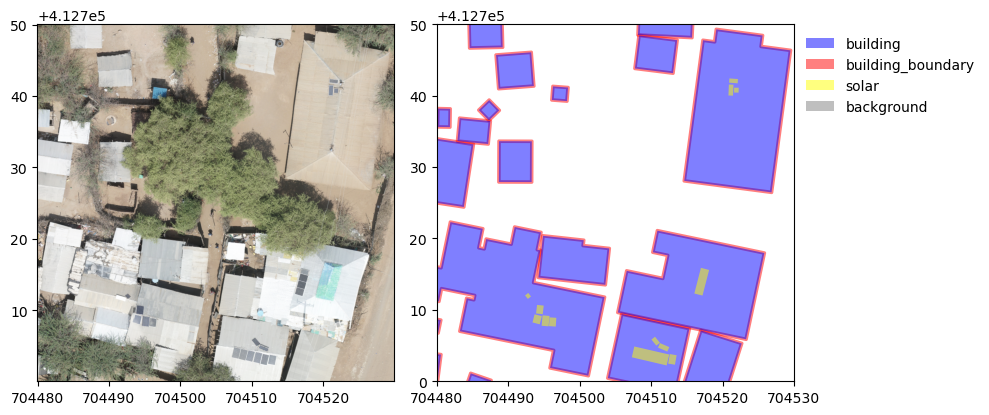

In [4]:
# Define colors for each class and map colors to classes in a new column
class_colors = {'building': 'blue', 'building_boundary': 'red', 'solar': 'yellow', 'background': 'gray'}
sem_seg_ann['color'] = sem_seg_ann['class'].map(class_colors)

# Define bounds for visualization in a small area
left, bottom, right, top = 704480, 412700, 704530, 412750

# Open the dataset and get the transform
imagery_file = '../data/interim/example_mosaic_cogs/kakuma_15.tif'
with rasterio.open(imagery_file) as src:
    transform = src.transform
    transformer = rasterio.transform.AffineTransformer(transform)

    # Convert the bounds to rows and cols
    row_start, col_start = transformer.rowcol(left, top)
    row_stop, col_stop = transformer.rowcol(right, bottom)

    # Create the window
    window = Window(col_off=col_start, row_off=row_start, width=col_stop-col_start, height=row_stop-row_start)

    # Read the imagery data from the window
    window_data = src.read(window=window)

    # Get the new transform
    new_transform = rasterio.windows.transform(window, transform)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the windowed imagery data on the first subplot
    show(window_data, ax=axs[0], transform=new_transform)
    
    # Plot the classes on the second subplot
    sem_seg_ann.plot(ax=axs[1], alpha=0.5, color=sem_seg_ann['color'])
    axs[1].set_xlim(left, right)
    axs[1].set_ylim(bottom, top)
    # Add patches for legend
    for class_name, color in class_colors.items():
        axs[1].fill([], [], color=color, alpha=0.5, label=class_name, edgecolor='none')
    axs[1].legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    
fig.tight_layout()
plt.show()

The above code cell displays a small window of the study area. The left plot shows the aerial imagery, while the right plot visualizes the segmentation annotations. Different colors represent various classes (buildings, building boundaries, solar panels, and background). Overlapping polygons are visible due to a semi-transparent fill. This allows us to see, for example, solar panels located within buildings and building boundaries that partially overlap with buildings.

## Creating Semantic Segmentation Masks with `create_mask.py`
Next, we use the polygons in the geopackage to burn semantic segmentation masks for model training. To do this, we use the `./scripts/semantic_segmentation/create_mask.py` script.

```bash
python create_mask.py -c ../../config/examples/semantic_segmentation/create_mask/create_mask-kakuma_15.yml --root-dir $PROJECT_ROOT
```
This creates a corresponding mask raster for a given input `image-file` from any semantic segmentation class objects in the input `label-file` that overlap spatially with the `image-file`. We ran this 4 times (once each for Kakuma_15, Kakuma_17, Kalobeyei_01, and Kalobeye_03) when using our full `semantic_segmentation_classes.gpkg` file spanning all of these regions.

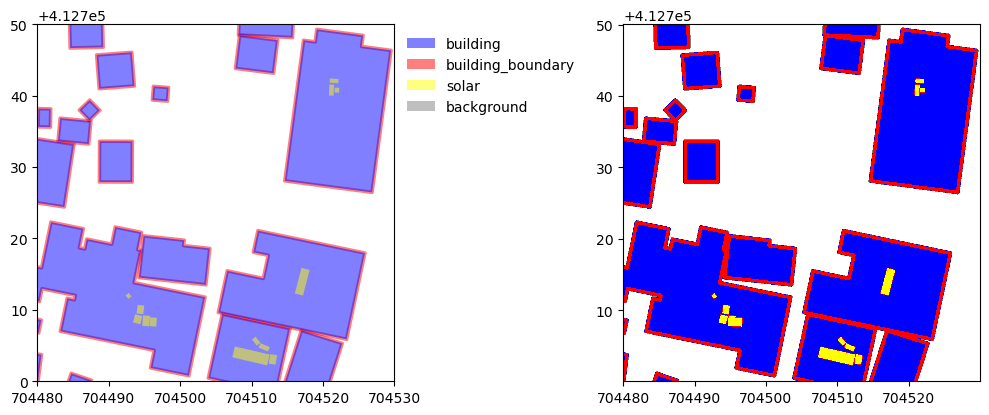

In [5]:
# Plot the semantic segmentation mask in the same area
segmentation_cmap = colors.ListedColormap(
    [(1,1,1), (0.5, 0.5, 0.5), (0,0,1), (1,0,0), (1,1,0)]
)
# Define bounds for visualization in a small area
left, bottom, right, top = 704480, 412700, 704530, 412750

# Open the dataset and get the transform
imagery_file = '../data/interim/example_masks/semantic_segmentation/kakuma_15.tif'
with rasterio.open(imagery_file) as src:
    transform = src.transform
    transformer = rasterio.transform.AffineTransformer(transform)

    # Convert the bounds to rows and cols
    row_start, col_start = transformer.rowcol(left, top)
    row_stop, col_stop = transformer.rowcol(right, bottom)

    # Create the window
    window = Window(col_off=col_start, row_off=row_start, width=col_stop-col_start, height=row_stop-row_start)

    # Read the data from the window
    window_data = src.read(window=window)

    # Get the new transform
    new_transform = rasterio.windows.transform(window, transform)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the classes on the first subplot
    sem_seg_ann.plot(ax=axs[0], alpha=0.5, color=sem_seg_ann['color'])
    axs[0].set_xlim(left, right)
    axs[0].set_ylim(bottom, top)
    # Add patches for legend
    for class_name, color in class_colors.items():
        axs[0].fill([], [], color=color, alpha=0.5, label=class_name, edgecolor='none')
    axs[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Plot the windowed data on the second subplot
    show(window_data, ax=axs[1], transform=new_transform, cmap=segmentation_cmap, vmin=0, vmax=4)

fig.tight_layout()
plt.show()

The preceding figure compares the vector semantic segmentation annotations with the raster mask. The left subplot shows the vector objects, while the right subplot displays the corresponding semantic segmentation mask. In areas where vector objects overlap, the segmentation mask values are determined by the label order argument provided to `create_mask.py`.

## Tiling Masks with `tile_raster.py`
Next, we'll tile these masks in the same way we did with the aerial imagery. However, we'll use the same tiling grid for the imagery to ensure that the imagery and mask tiles align spatially. We'll specify the mask we just created as the `input-raster` and use the `grid-init-file` argument to provide the grid we used for tiling the imagery in a configuration file.

```yml
---
input-raster: data/interim/example_masks/semantic_segmentation/kakuma_15.tif
tiles-output: data/processed/example_tiled_datasets/tile_size_500/semantic_segmentation/masks
grid-init-file: data/interim/example_tiling_grids/tile_size_500/kakuma_15_grid.shp
save-grid-image: reports/figures/example_tiled_datasets/tile_size_500/kakuma_15_mask.png
```
To execute the tiling, we run the following command:
```bash
python tile_raster.py -c ../../config/examples/semantic_segmentation/tile_raster/tile_raster-kakuma_15_mask.yml -r $PROJECT_ROOT
```
Visualizing the tiled mask:

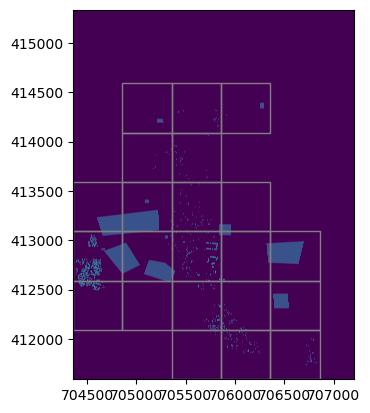

In [6]:
from IPython.display import Image
Image('../reports/figures/example_tiled_datasets/tile_size_500/kakuma_15_mask.png')

## Creating a Pre-Chipped Dataset with `sample_chips.py`

Next, we'll generate a pre-chipped dataset for our semantic segmentation task. Our goal is to include samples that represent solar panels, buildings without solar panels, and background elements (i.e., areas that are neither buildings nor solar panels). 

This approach is beneficial because solar panels, which are crucial for our task, only make up a small fraction of the pixels in the imagery. If we were to sample chips randomly from the tiles, we'd seldom encounter solar panels. By creating a pre-chipped dataset, we can ensure that our training data adequately represents all the classes we need to learn. Here's how we do it:
```bash
cd scripts/semantic_segmentation
python sample_chips.py --config ../../config/examples/semantic_segmentation/sample_chips.yml --root-dir $PROJECT_ROOT
```